# <center>Incremental Deep Learning

## Overview

The idea behind Incremental Dynamic Learning networks is that information is not always learned at once, up front. As information is encountered, we train on the new data. Adding the new information to our existing knowlege base. Humans, are said to be able to recognize an image in 13 milliseconds after seeing it.The new image is added to their existing learned information and they do not have to retrain on all images they have ever seen.

## Example

As an example of how this can be used in the real world, I will use field biologists for my use case.

Imagine a group of field biologists are in the field and all have a mobile application which allows them to photograph wildlife they encounter, label it and forward it to a central system. The central system takes in the new photographs and trains a neural network on each piece of new data that comes in. W/out having to retrain a new model based on all past photographs. 

## Experiment 1

The experiment will consist of using a pre-trained network from TensorFlow (VGG) to generate our classification data. Our data will consist of using flower images provided with TensorFlow examples.

Once the data has be converted by the VGG network, the process of training our network begins. This will be done by feeding the network 1 image at a time, allowing the network to train for a short duration (13ms) and then move onto the next image. A fixed validation set will be used to monitor progress as the images are fed one at a time to the network.

The goal is to get an acceptable accuracy, similar to what a traditionally trained network would achieve. Below is the accuracy aceived from a lesson on Transfer Learning from UDACITY.

![](docs/UDACITY-Transfer_Learning_Test_Accuracy.PNG)

### General Imports

## Network Construction

The firs thing we will do is construct our networks. We will use 3 different network models for this experiment:
* The Convolutional Network (VGG16) - Used to convolve our images
* The Classification Network (Dence Network) - Used to validate our training
* Full model network (Convolutional + Classification) - Used to train our Classification network.

The full model will actually be made of of layers from the Convolutional network and the Classification network. It will perform the job of convolving the images and classifying them. This is the model we will use to train our network.

These models are separated to allow the experiment to be run more efficiently and will be used for different functions thruout the experiment. By convolving our validation and test data up front, we will eliminate a good deal of redundent processing of the same data. This will allow us not to perform a validation step during each training epoch, and give us the flexibility of performing a validation step after some number of images are trained. Thus allowing us to monitor the progress of our work.

One thing to note is that we will make all the VGG16 layers not trainable and we will not include the top layer (because we are providing our own classifier.) This will allow us to feed our images into the full model, but train only the classification layer.

In [2]:
import os
from os.path import isfile, isdir
from tqdm import tqdm
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

print ('TensorFlow version: {}'.format(tf.VERSION))

TensorFlow version: 1.4.0


### Get sample data

Let's pull down some sample data using photos of flowers provided by TensorFlow.

In [3]:
import tarfile
from urllib.request import urlretrieve

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

### Read a sample image to test our networks

Image shape: (224, 224, 3)


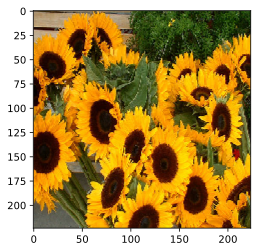

In [37]:
data_dir = 'flower_photos/'

test_img = tf.keras.preprocessing.image.load_img(data_dir + 'sunflowers/6953297_8576bf4ea3.jpg', target_size=(224,224,3))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
test_img = test_img.astype(np.uint8) 

print ('Image shape: {}'.format(test_img.shape))
plt.imshow(test_img)

### Convolutional Network

In [14]:
def build_conv_model(input_shape=(224,224,3), summary=False):

    model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

    for layer in model.layers:
        layer.trainable = False

    if summary:
        model.summary()
    return model

conv_model = build_conv_model(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Use the conv model to convolve the image

In [15]:
conv_model = build_conv_model()
feed_image = np.expand_dims(test_img, axis=0)
convolved_img = conv_model.predict(feed_image)

print ('Convolved image shape: {}'.format(convolved_img.shape))

conv_out_layer = conv_model.layers[-1]

print ('Shape of output layer is {}'.format(conv_out_layer.get_output_at(0).get_shape()))

Convolved image shape: (1, 512)
Shape of output layer is (?, 512)


### Classification Network

Here we are free to experiment with various dense layers and configurations. I have found initializing both the weights and the biases to zero produces good resluts. Also a low learning rate worked very well in producing more accurate results.

In [19]:
def build_classifcation_model(conv_model, learning_rate=0.0001, classes=5, summary=False):
    model = tf.keras.models.Sequential()
    
    input_shape = conv_model.layers[-1].output_shape[1]
    model.add(tf.keras.layers.Dense(256, input_shape=[input_shape]))
    model.add(tf.keras.layers.Dense(classes, 
                           kernel_initializer='zeros', 
                           bias_initializer='zeros'))

    model.add(tf.keras.layers.Activation('softmax', name='out'))
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    return model

conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model, summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1285      
_________________________________________________________________
out (Activation)             (None, 5)                 0         
Total params: 132,613
Trainable params: 132,613
Non-trainable params: 0
_________________________________________________________________


### Use the classification model to train on an convolved image

In [8]:
conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model)
feed_image = np.expand_dims(test_img, axis=0)
convolved_img = conv_model.predict(feed_image)
label = [0, 0, 0, 1, 0]
label = np.expand_dims(label, axis=0)
classification_model.fit(convolved_img, label, epochs=1)

pred = classification_model.predict_classes(convolved_img)
print ('prediction is {}'.format(pred))

Epoch 1/1
1/1 [==============================] - 0s
prediction is [3]


### Construct full network using layers from conv and classifcation models

In [9]:
def build_full_model(conv_model, classification_model, learning_rate=0.0001, summary=False):
    # Allocate pre-built model and make non-trainable
    model = tf.keras.models.Sequential()
    for layer in conv_model.layers:
        model.add(layer)
    
    for layer in classification_model.layers:
        model.add(layer)
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    return model

conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model)
full_model = build_full_model(conv_model, classification_model, summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Train the full model on the original image

In [10]:
conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model)
full_model = build_full_model(conv_model, classification_model)
feed_image = np.expand_dims(test_img, axis=0)
label = [0, 0, 0, 1, 0]
label = np.expand_dims(label, axis=0)
full_model.fit(feed_image, label, epochs=1)

pred = full_model.predict_classes(feed_image)
print ('full prediction is {}'.format(pred))

# Demonstrate the classification model was also trained
convolved_img = conv_model.predict(feed_image)
pred = classification_model.predict_classes(convolved_img)
print ('classification prediction is {}'.format(pred))

Epoch 1/1
1/1 [==============================] - 0s
full prediction is [3]
1/1 [==============================] - 0s
classification prediction is [3]


# <center>**_Run all Cells from here on up when restarting _**</center>

![](docs/up_arrows.png "Restart")

## Read all the images, reshape the images and create labels for them

In [38]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

images = []
labels = []
batch = []

for each in classes:
    print("Starting {} images".format(each))
    class_path = data_dir + each
    files = os.listdir(class_path)
    for ii, file in enumerate(files, 1):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
        img = tf.keras.preprocessing.image.load_img(os.path.join(class_path, file), target_size=(224,224,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img.astype(np.uint8) 
        images.append(img)
        labels.append(each)

        # Display progress
        if ii % 250 == 0 or ii == len(files):
            print('{} images processed'.format(ii))
            
images = np.concatenate(images)

print ('Image loading complete: {}'.format(images.shape))

Starting daisy images
250 images processed
500 images processed
633 images processed
Starting dandelion images
250 images processed
500 images processed
750 images processed
898 images processed
Starting roses images
250 images processed
500 images processed
641 images processed
Starting sunflowers images
250 images processed
500 images processed
699 images processed
Starting tulips images
250 images processed
500 images processed
750 images processed
799 images processed
Image loading complete: (3670, 224, 224, 3)


In [20]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
classes = lb.classes_
print (labels_vecs.shape)
print (classes)

(3670, 5)
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


## Generate the training, validation and test data sets

In [21]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_vecs, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

print ('Train shape: {}'.format(X_train.shape))
print ('Validation shape: {}'.format(X_val.shape))
print ('Test shape: {}'.format(X_test.shape))

C:\Users\nmaio\Anaconda3\envs\tf-14\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train shape: (2936, 224, 224, 3)
Validation shape: (367, 224, 224, 3)
Test shape: (367, 224, 224, 3)


In [ ]:
rand_image = np.random.randint(0, len(X_train) - 1)
sample_image = X_train[rand_image]
sample_label = y_train[rand_image]
print (sample_label)
print (classes[np.argmax(sample_label)])
plt.imshow(sample_image)

### Convolve validation and test images

Since we want to be efficient during this incremental learning simulation, it would be more efficient to convolve the validation and train images now.

In [ ]:
conv_model = build_conv_model()

X_val_conv = conv_model.predict(X_val)
X_test_conv = conv_model.predict(X_test)

print (X_val_conv.shape)
print (X_test_conv.shape)

## <center>Checkpoint Save

### Save the data

In [ ]:
if not isdir('data'):
    os.mkdir('data')
    
np.savez_compressed('data/data.npz',
                    classes=classes,
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    X_test=X_test,
                    y_test=y_test,
                    X_val_conv=X_val_conv,
                    X_test_conv=X_test_conv)

## <center>Checkpoint Load

<center>Make sure you ran all the cells as directed above first.

### Load training, validation, test, convolved validation and convovled test data

In [24]:
data_load = np.load('data/data.npz')
classes = data_load['classes']
X_train = data_load['X_train']
y_train = data_load['y_train']
X_val = data_load['X_val']
y_val = data_load['y_val']
X_test = data_load['X_test']
y_test = data_load['y_test']
X_val_conv = data_load['X_val_conv']
X_test_conv = data_load['X_test_conv']

### Tiny datasets

If you would like to work with a smaller dataset during your development/experimental phase, you can reduce the datasets here.

In [ ]:
X_train = X_train[0:20]
y_train = y_train[0:20]

### Build initial models...

In [ ]:
conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model, classes=len(classes))
full_model = build_full_model(conv_model, classification_model)

## ... Or load existing models

In [28]:
conv_model = tf.keras.models.load_model('models/conv_model.h5')
classification_model = tf.keras.models.load_model('models/classification_model.h5')
full_model = build_full_model(conv_model, classification_model)

### Get a sample image

[0 0 0 1 0]
sunflowers


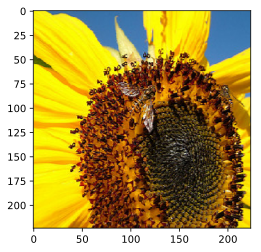

In [29]:
rand_image = np.random.randint(0, len(X_train) - 1)
sample_image = X_train[rand_image]
sample_label = y_train[rand_image]
print (sample_label)
print (classes[np.argmax(sample_label)])
plt.imshow(sample_image)

## Generate more training images

Here we use the image data generator provided by Keras to create variations on a single image to provide more training data.

In [30]:
datagen = preprocessing.image.ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.01,
        height_shift_range=0.01,
        shear_range = 0.01,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='reflect')

def gen_batch(image, label, count=9):
    batch_data = []
    batch_labels = []
    img = np.expand_dims(image, axis=0)
    batch_data.append(img)
    batch_labels.append(label.tolist())
    for X_batch in datagen.flow(x=img):
        gen_image = X_batch[0]
        gen_image = np.expand_dims(gen_image, axis=0)
        gen_image = gen_image.astype(np.uint8) 
        batch_data.append(gen_image)
        batch_labels.append(label.tolist())
        if len(batch_data) > count - 1:
            batch_data = np.concatenate(batch_data)
            return batch_data, batch_labels

## Generate 8 more images and display them

[0 0 0 1 0]


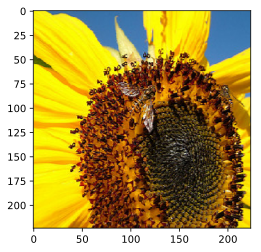

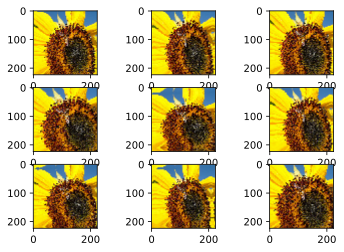

In [31]:
print(sample_label)
plt.imshow(sample_image)
plt.show()


batch_images, batch_labels = gen_batch(sample_image, sample_label, count=9)
i = 0
for image, label in zip(batch_images, batch_labels):
    plt.subplot(330 + 1 + i)
    plt.imshow(image)
    i += 1
    
# show the plot    
plt.show()

### Test train on the generated batch of images and labels

In [ ]:
batch_images, batch_labels = gen_batch(sample_image, sample_label, count=9)
conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model, classes=len(classes))
full_model = build_full_model(conv_model, classification_model)

full_model.fit(batch_images, batch_labels, batch_size=9, epochs=1, verbose=True)

## Simulate images being trained as they arrive

In [ ]:
def learn_image(image, label, epochs=3):
    batch_images, batch_labels = gen_batch(image, label, count=9)
    remember_image = np.expand_dims(batch_images[0], axis=0)
    remember_class = np.argmax(label)
    memory_class = full_model.predict_classes(remember_image, verbose=False)
    if remember_class != memory_class:
        epochs = 13
    
    X_train_conv = conv_model.predict(batch_images)
    
    history = classification_model.fit(X_train_conv, batch_labels, batch_size=9, epochs=epochs, verbose=False)
    return history

In [ ]:
conv_model = build_conv_model()
classification_model = build_classifcation_model(conv_model, classes=len(classes))
full_model = build_full_model(conv_model, classification_model)

for index in range(len(X_train)):
    print ('\rImage: {}'.format(index), end='')
    single_image = X_train[index]
    single_label = y_train[index]
    history = learn_image(single_image, single_label)
    
    if index % 100 == 0:
        verbose = True
        evaluation = classification_model.evaluate(X_val_conv, y_val, batch_size=len(X_val_conv), verbose=True)
        print ('Valdidation: ', evaluation)
    else:
        verbose = False
    
evaluation = classification_model.evaluate(X_test_conv, y_test, verbose=True)
print()
print('Test: ', evaluation)

In [ ]:
evaluation = full_model.evaluate(X_test, y_test, verbose=True)
print('Test Full Model: ', evaluation)

In [ ]:
if not isdir('models'):
    os.mkdir('models')
    
conv_model.save('models/conv_model.h5')
classification_model.save('models/classification_model.h5')

tulips


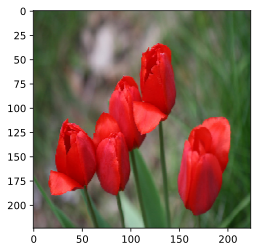

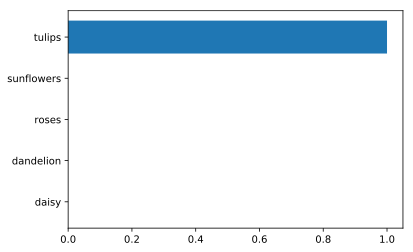

In [36]:
rand_image = np.random.randint(0, len(X_train) - 1)
sample_image = X_train[rand_image]
sample_label = y_train[rand_image]
print (classes[np.argmax(sample_label)])

plt.imshow(sample_image)
plt.show()

feed_image = np.expand_dims(sample_image, axis=0)
pred = full_model.predict(feed_image)

plt.barh(np.arange(5), pred[0])
_ = plt.yticks(np.arange(5), classes)